In [19]:
# !pip install tensorflow-datasets
# !pip install tensorflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

noise_file = np.load('./data/CIFAR-10_human_ordered.npy', allow_pickle=True)
clean_label = noise_file.item().get('clean_label')
worst_label = noise_file.item().get('worse_label')
aggre_label = noise_file.item().get('aggre_label')
random_label1 = noise_file.item().get('random_label1')
random_label2 = noise_file.item().get('random_label2')
random_label3 = noise_file.item().get('random_label3')

classess_name = {0: 'airplane',
 1:'automobile',
 2:'bird',
 3:'cat',
 4:'deer',
 5:'dog',
 6:'frog',
 7:'horse',
 8:'ship',
 9:'truck'}

batch_size=128
input_size = 3*32*32
output_size = 10
torch.manual_seed(43)
val_size = 5000
train_size = 50000 - val_size

# The noisy label matches with following tensorflow dataloader
train_ds, test_ds = tfds.load('cifar10', split=['train','test'], as_supervised=True, batch_size = -1)
# train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
# test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)
train_images, train_labels = tfds.as_numpy(train_ds) 
test_images, test_labels = tfds.as_numpy(test_ds) 
# You may want to replace train_labels by CIFAR-N noisy label sets
print(train_images.shape, train_labels.shape,test_images.shape, test_labels.shape)

# # building the input vector from the 32x32 pixels
X_train = train_images.reshape(train_images.shape[0], 32, 32, 3)
X_test = test_images.reshape(test_images.shape[0], 32, 32, 3)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding train_labels: ", train_labels.shape)
print("Shape before one-hot encoding X_train: ", X_train.shape)
Y_train = np_utils.to_categorical(train_labels, n_classes)
Y_test = np_utils.to_categorical(test_labels, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)
Shape before one-hot encoding train_labels:  (50000,)
Shape before one-hot encoding X_train:  (50000, 32, 32, 3)
Shape after one-hot encoding:  (50000, 10)


In [20]:
from keras import layers
simple_aug = tf.keras.Sequential(
    [
        layers.Resizing(32, 32),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ]
)

# Now, map the augmentation pipeline to our training dataset
train_ds_simple = (
    tf.data.Dataset.from_tensor_slices((X_train, Y_train))
#     .shuffle(batch_size * 100)
    .batch(batch_size)
    .map(lambda x, y: (simple_aug(x), y))
#     .prefetch(AUTO)
)

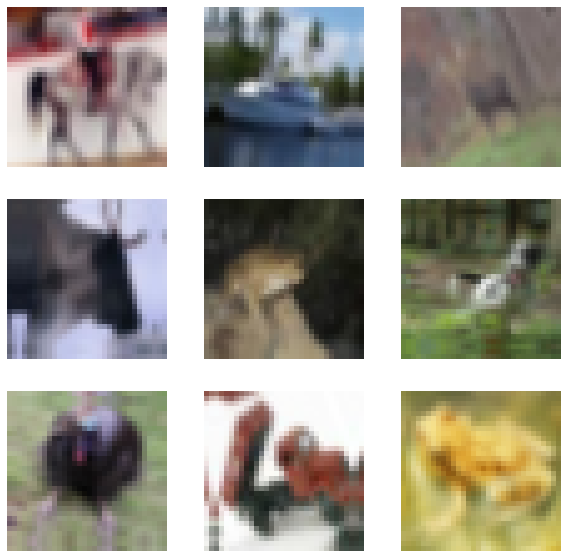

In [21]:
sample_images, _ = next(iter(train_ds_simple))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")

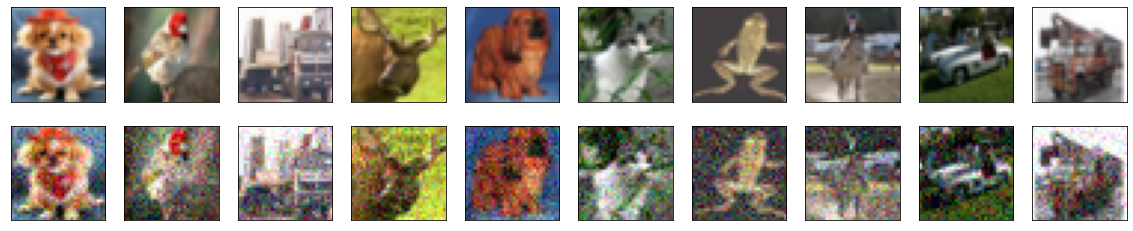

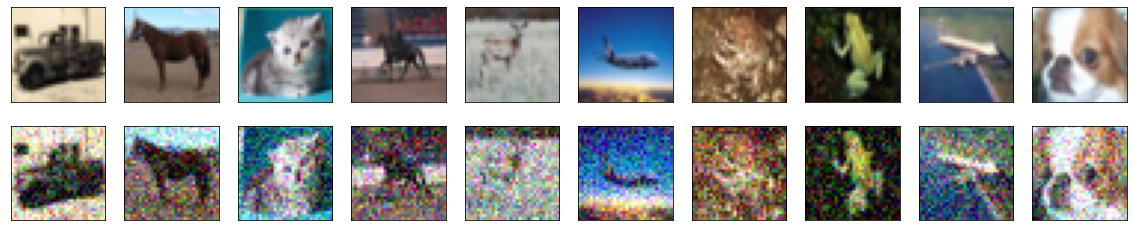

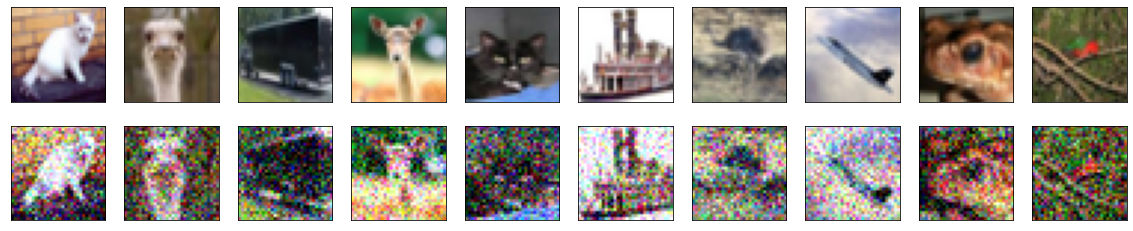

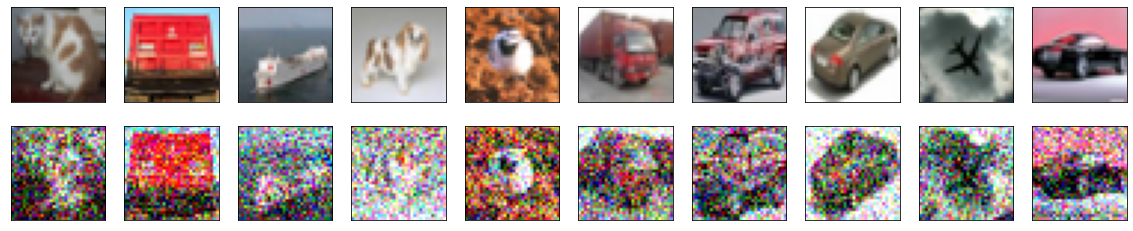

In [24]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def noise(array, noise_factor):
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    
    return np.clip(noisy_array, 0.0, 1.0)

def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

# Create a copy of the data with added noise
noisy_train_data1 = noise(X_train, 0.1)
noisy_train_data2 = noise(X_train, 0.15)
noisy_train_data3 = noise(X_train, 0.2)
noisy_train_data4 = noise(X_train, 0.25)
noisy_test_data = noise(X_test, 0.2)

# Display the train data and a version of it with added noise
display(X_train, noisy_train_data1)
display(X_train, noisy_train_data2)
display(X_train, noisy_train_data3)
display(X_train, noisy_train_data4)